In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone
%matplotlib inline

In [2]:
df = pd.read_csv("/kaggle/input/ad-click-prediction-dataset/ad_click_dataset.csv")
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


In [4]:
for column in df.columns:
    unique_values=df[column].unique()
    print(f'Unique values in column {column}')
    print(unique_values)
    print("------------------------------------")

Unique values in column id
[ 670 3044 5912 ... 7843 3914 3056]
------------------------------------
Unique values in column full_name
['User670' 'User3044' 'User5912' ... 'User7843' 'User3914' 'User3056']
------------------------------------
Unique values in column age
[22. nan 41. 34. 39. 26. 40. 47. 19. 56. 24. 52. 42. 36. 43. 62. 45. 37.
 31. 58. 59. 48. 38. 49. 30. 46. 54. 44. 27. 57. 28. 51. 25. 61. 32. 64.
 23. 55. 21. 20. 35. 53. 33. 29. 63. 50. 18. 60.]
------------------------------------
Unique values in column gender
[nan 'Male' 'Non-Binary' 'Female']
------------------------------------
Unique values in column device_type
['Desktop' nan 'Mobile' 'Tablet']
------------------------------------
Unique values in column ad_position
['Top' 'Side' nan 'Bottom']
------------------------------------
Unique values in column browsing_history
['Shopping' nan 'Education' 'Entertainment' 'Social Media' 'News']
------------------------------------
Unique values in column time_of_day
['Aft

In [5]:
print("Duplicate Values:")
print(df.duplicated().sum())
print("----------------------")
print("Missing Values:")
print(df.isnull().sum().sum())
print("----------------------")
print("Missing Values for each columns:")
print(df.isnull().sum())
print("----------------------")

Duplicate Values:
2853
----------------------
Missing Values:
20241
----------------------
Missing Values for each columns:
id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64
----------------------


In [6]:
df = df.drop_duplicates()
print("Duplicate Values:")
print(df.duplicated().sum())
df.info()

Duplicate Values:
0
<class 'pandas.core.frame.DataFrame'>
Index: 7147 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7147 non-null   int64  
 1   full_name         7147 non-null   object 
 2   age               3671 non-null   float64
 3   gender            3747 non-null   object 
 4   device_type       5419 non-null   object 
 5   ad_position       5404 non-null   object 
 6   browsing_history  3667 non-null   object 
 7   time_of_day       5435 non-null   object 
 8   click             7147 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 558.4+ KB


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


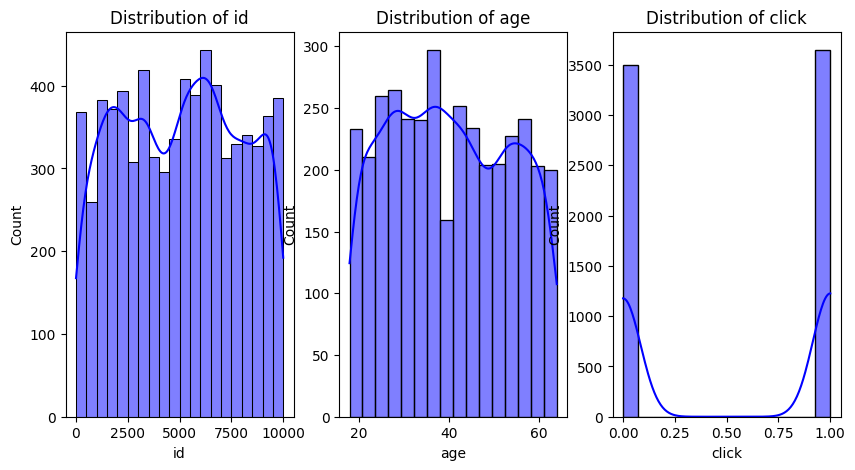

In [7]:
plt.figure(figsize=(10,5))
for i, a in enumerate(df.select_dtypes(exclude=['object']).columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df, x=a, kde=True, color= 'Blue')
    plt.title(f"Distribution of {a}")
plt.show()

In [8]:
# Using bf for some columns 
df['time_of_day'].fillna('bf', inplace=True)
df['ad_position'].fillna('bf', inplace=True)
df['device_type'].fillna('bf', inplace=True)

<ipython-input-8-b3b83a0f7607>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_of_day'].fillna('bf', inplace=True)
<ipython-input-8-b3b83a0f7607>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [9]:
df['gender'] = df['gender'].fillna('Unknown')
df['browsing_history'] = df['browsing_history'].fillna("Unknown")

In [10]:
df.isnull().sum()

id                     0
full_name              0
age                 3476
gender                 0
device_type            0
ad_position            0
browsing_history       0
time_of_day            0
click                  0
dtype: int64

In [11]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,Unknown,bf,1
2,5912,User5912,41.0,Non-Binary,bf,Side,Education,Night,1
3,5418,User5418,34.0,Male,bf,bf,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,bf,bf,Social Media,Morning,0


In [12]:
from sklearn.impute import KNNImputer

def knn_impute(data, n_neighbors=5):
    data_encoded = data.copy()

    category_mappings = {}
    for col in data_encoded.select_dtypes(include='object').columns:
        data_encoded[col] = data_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(data[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_encoded), columns = data_encoded.columns)

    for col in data.select_dtypes(include='object').columns:
        data_imputed[col] = data_imputed[col].round().astype(int).map(category_mappings[col])

    return data_imputed

data_imputed = knn_impute(df, n_neighbors=5)
df = data_imputed

In [13]:
df.isnull().sum()

id                  0
full_name           0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

In [14]:
df.drop(['id', 'full_name'], axis=1, inplace=True)

In [15]:
df.head()

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,Unknown,Desktop,Top,Shopping,Afternoon,1.0
1,34.0,Male,Desktop,Top,Unknown,bf,1.0
2,41.0,Non-Binary,bf,Side,Education,Night,1.0
3,34.0,Male,bf,bf,Entertainment,Evening,1.0
4,39.0,Non-Binary,bf,bf,Social Media,Morning,0.0


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


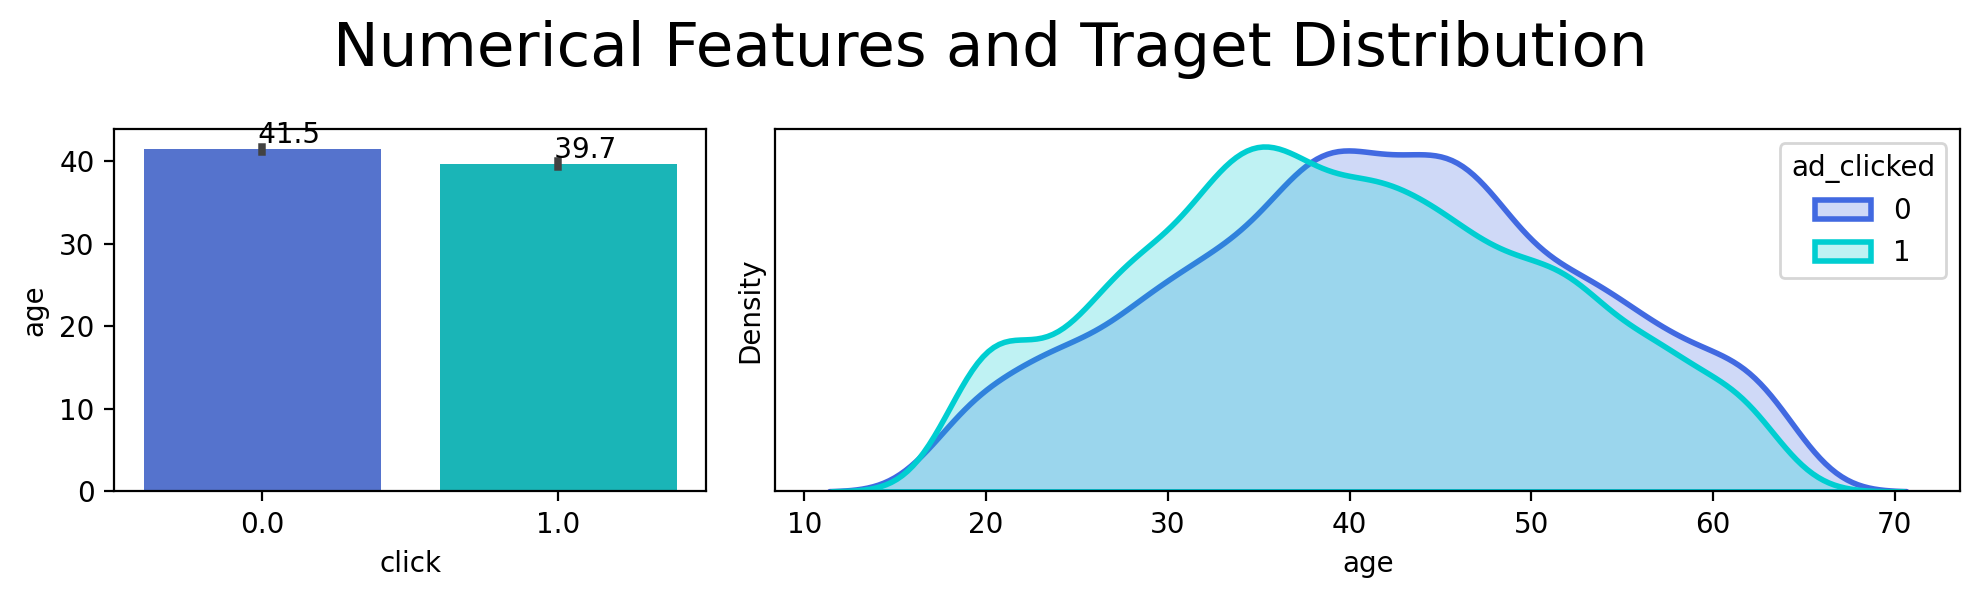

In [16]:
Num_Features = ['age']

sns.set_palette(['royalblue', 'darkturquoise'])

Target = 'click'
fig, ax = plt.subplots(1, 2, figsize=(10,3), dpi=200, gridspec_kw={'width_ratios' : [1, 2]})

for i, col in enumerate(Num_Features):
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i])

sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i+1], label='0')
sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i+1], label='1')
ax[i+1].set_yticks([])
ax[i+1].legend(title='ad_clicked', loc='upper right')

for cont in graph.containers:
    graph.bar_label(cont, fmt='      %.3g')

plt.suptitle("Numerical Features and Traget Distribution", fontsize=22)
plt.tight_layout()
plt.show()

In [17]:
df['gender'] = df['gender'].replace({'Unknown' : 1, "Female" : 2, "Male" : 3, "Non-Binary" : 4})
df['device_type'] = df['device_type'].replace({'Desktop' : 1, "Mobile": 2, "Tablet": 3, "bf" : 4})
df['browsing_history'] = df['browsing_history'].replace({"Unknown" : 1, "Social Media": 2, "Education": 3, "Shopping" : 4, "News": 5, "Entertainment" : 6})
df['ad_position'] = df['ad_position'].replace({"Bottom": 1, "Top": 2, "Side" :3, "bf": 4})
df['time_of_day'] = df['time_of_day'].replace({"Morning":1, "Afternoon": 2, "bf": 3, "Evening": 4, "Night": 5})

<ipython-input-17-36b04cd50802>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Unknown' : 1, "Female" : 2, "Male" : 3, "Non-Binary" : 4})
<ipython-input-17-36b04cd50802>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['device_type'] = df['device_type'].replace({'Desktop' : 1, "Mobile": 2, "Tablet": 3, "bf" : 4})
<ipython-input-17-36b04cd50802>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly 

In [18]:
df1 = df.copy()

In [19]:
df1.head()

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,1,1,2,4,2,1.0
1,34.0,3,1,2,1,3,1.0
2,41.0,4,4,3,3,5,1.0
3,34.0,3,4,4,6,4,1.0
4,39.0,4,4,4,2,1,0.0


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147 entries, 0 to 7146
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               7147 non-null   float64
 1   gender            7147 non-null   int64  
 2   device_type       7147 non-null   int64  
 3   ad_position       7147 non-null   int64  
 4   browsing_history  7147 non-null   int64  
 5   time_of_day       7147 non-null   int64  
 6   click             7147 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 391.0 KB


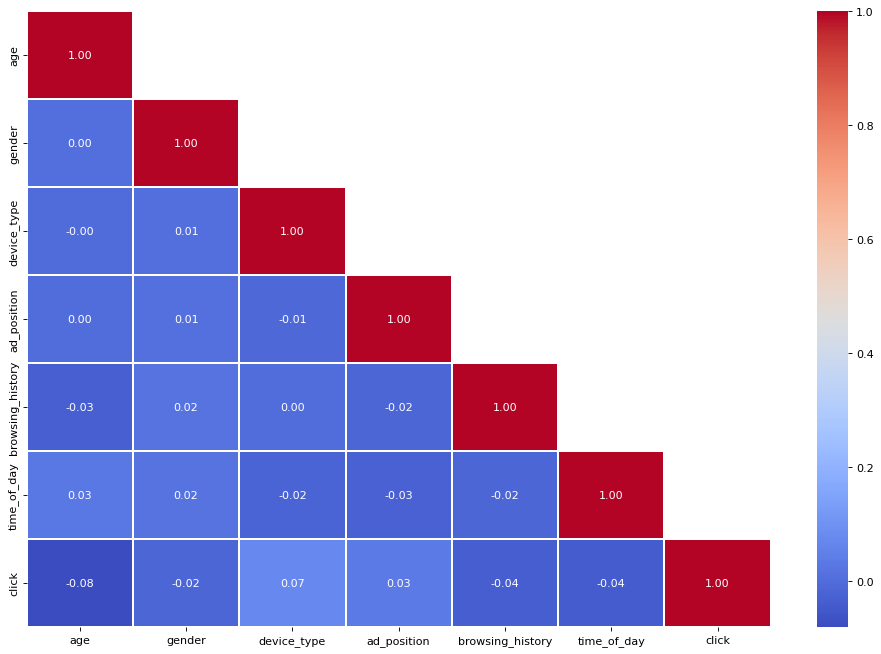

In [21]:
target = 'click'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(15,10), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.2)
plt.show()

In [22]:
X=df1.drop('click', axis=1)
y=df1['click']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
def metrics_calculator(clf, X_test, y_test, model_name):
   
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result

In [25]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    
    sns.set(font_scale=1.2)

   
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    # Create figure and subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})

    
    royalblue_r = LinearSegmentedColormap.from_list('royalblue_r', ['royalblue', 'white'])


    
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')

    
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show()

In [26]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    
   
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

    
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    
    clf_grid.fit(X_train, y_train)

   
    best_hyperparameters = clf_grid.best_params_

    
    return clf_grid.best_estimator_, best_hyperparameters

In [27]:
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

In [28]:
X = df.drop('click', axis=1)
y = df['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0 , stratify=y)

dt_base = DecisionTreeClassifier(random_state=0)


param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(8, 15),  
    'min_samples_split': np.arange(2, 5),  
    'min_samples_leaf': np.arange(1, 5),
    'max_features': [None, 'sqrt'],
    'class_weight': [{0: 1, 1: w} for w in [1.0, 1.5, 2.0]] } 

best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2.0}, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.75      0.24      0.36      2800
         1.0       0.56      0.92      0.70      2917

    accuracy                           0.59      5717
   macro avg       0.65      0.58      0.53      5717
weighted avg       0.65      0.59      0.53      5717


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.62      0.19      0.29       700
         1.0       0.53      0.89      0.67       730

    accuracy                           0.55      1430
   macro avg       0.58      0.54      0.48      1430
weighted avg       0.58      0.55      0.48      1430



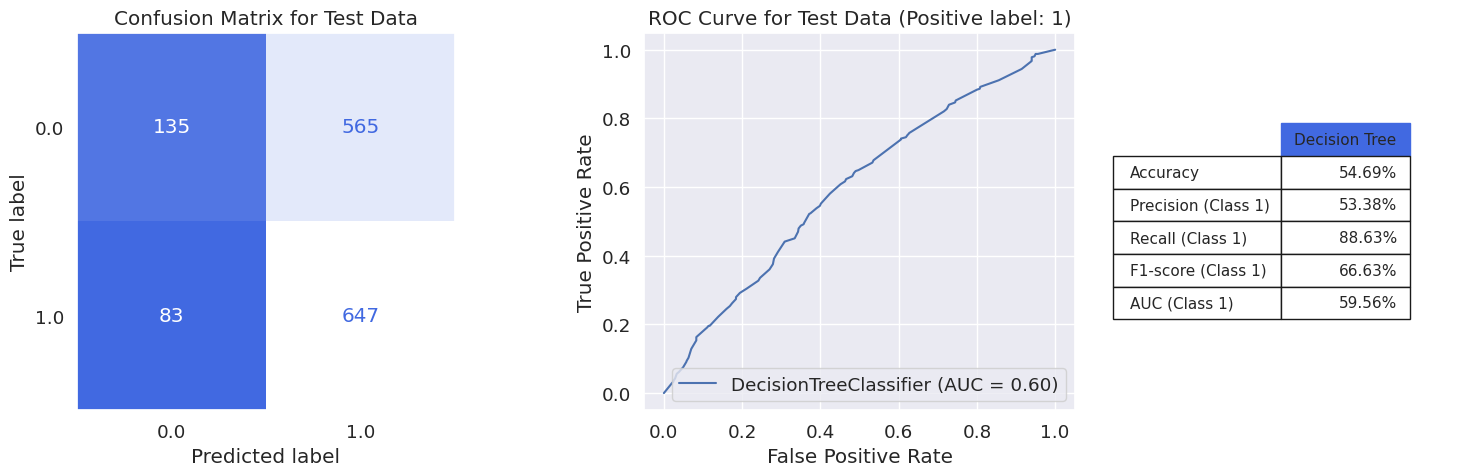

In [29]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [30]:
dt_result = metrics_calculator(best_dt, X_test, y_test, 'DT')
dt_result

,DT
Accuracy,54.69%
Precision (Class 1),53.38%
Recall (Class 1),88.63%
F1-score (Class 1),66.63%
AUC (Class 1),59.56%


In [31]:
from sklearn.ensemble import RandomForestClassifier


rf_base = RandomForestClassifier(random_state=0)


param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'criterion': ['entropy'],
    'max_depth': [14,16,18],
    'min_samples_split': [4, 5],
    'min_samples_leaf': [3, 5],
    'class_weight': [{0: 1, 1: w} for w in [1.5,2]],
    'max_features': ['sqrt', 'log2']
}


best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)

In [32]:
print('Random Forest Optimal Hyperparameters: \n', best_rf_hyperparams)

Random Forest Optimal Hyperparameters: 
 {'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.45      0.62      2800
         1.0       0.65      0.98      0.78      2917

    accuracy                           0.72      5717
   macro avg       0.81      0.72      0.70      5717
weighted avg       0.80      0.72      0.70      5717


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.73      0.31      0.43       700
         1.0       0.57      0.89      0.70       730

    accuracy                           0.61      1430
   macro avg       0.65      0.60      0.57      1430
weighted avg       0.65      0.61      0.57      1430



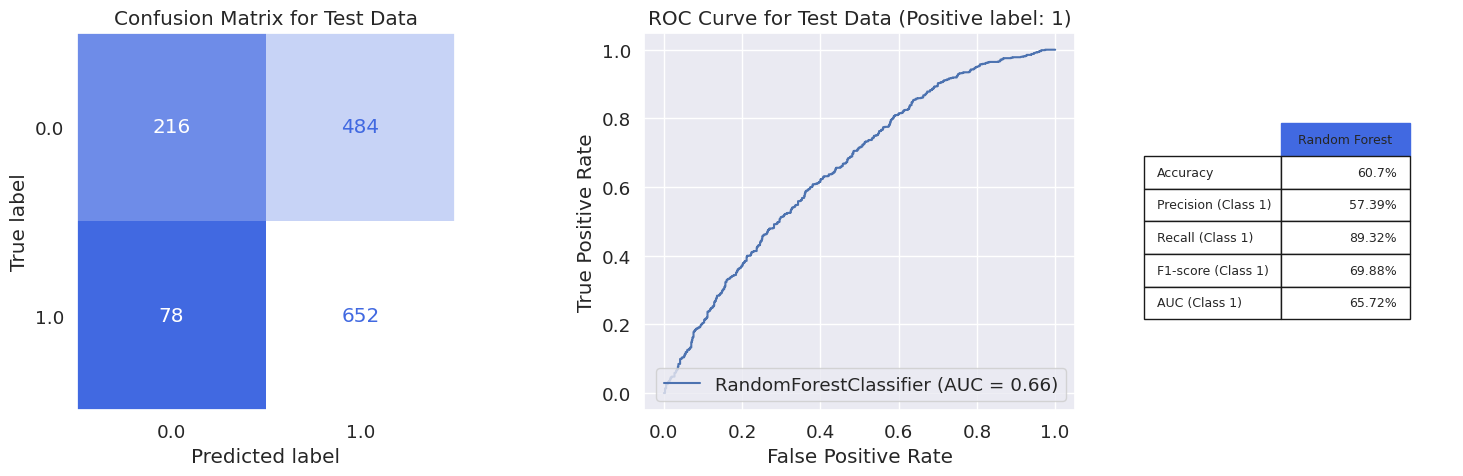

In [33]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [34]:
rf_result = metrics_calculator(best_rf, X_test, y_test, 'RF')
rf_result

,RF
Accuracy,60.7%
Precision (Class 1),57.39%
Recall (Class 1),89.32%
F1-score (Class 1),69.88%
AUC (Class 1),65.72%


In [35]:
xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)


param_grid_xgb = {

    'scale_pos_weight': [1.5,2],

}

best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)

In [36]:
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

XGBoost Optimal Hyperparameters: 
 {'scale_pos_weight': 2}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81      2800
         1.0       0.77      0.99      0.86      2917

    accuracy                           0.84      5717
   macro avg       0.87      0.84      0.84      5717
weighted avg       0.87      0.84      0.84      5717


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.83      0.53      0.65       700
         1.0       0.67      0.90      0.76       730

    accuracy                           0.72      1430
   macro avg       0.75      0.71      0.71      1430
weighted avg       0.75      0.72      0.71      1430



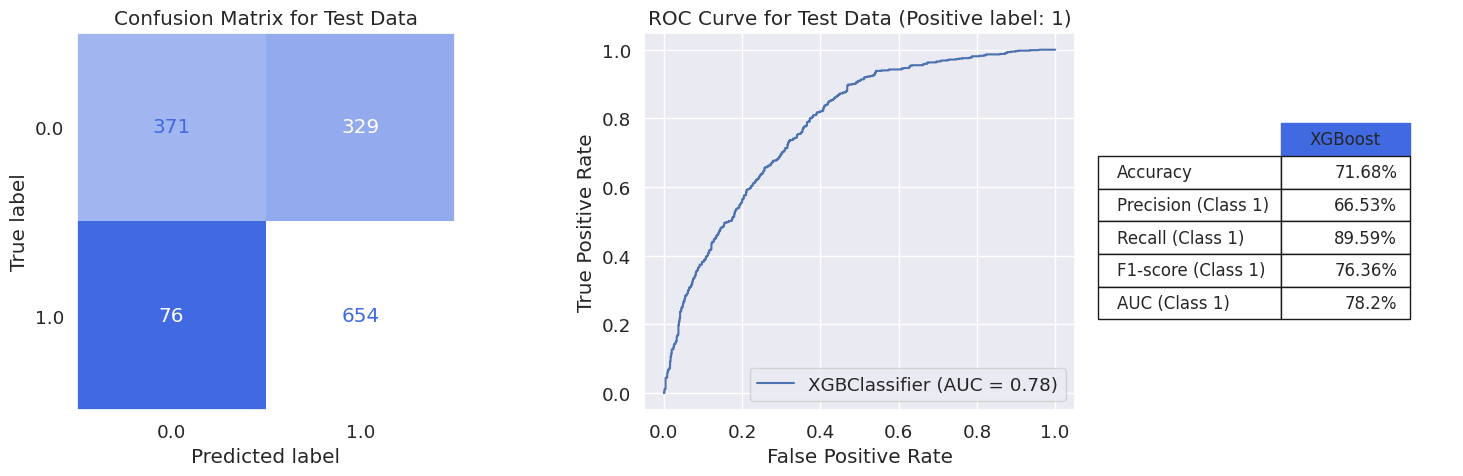

In [37]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [38]:
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGB')
xgb_result

,XGB
Accuracy,71.68%
Precision (Class 1),66.53%
Recall (Class 1),89.59%
F1-score (Class 1),76.36%
AUC (Class 1),78.2%


In [39]:
results = pd.concat([dt_result,xgb_result,rf_result], axis=1).T

results.reset_index(inplace=True) 

results = results.loc[:,~results.columns.duplicated()] 


results.index.name = 'Model' 



results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)


results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

<ipython-input-39-019d7134fc41>:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')


,index,Accuracy,Precision (Class 1),Recall (Class 1),F1-score (Class 1),AUC (Class 1)
Model,,,,,,
1,XGB,71.68%,66.53%,89.59%,76.36%,78.2%
2,RF,60.7%,57.39%,89.32%,69.88%,65.72%
0,DT,54.69%,53.38%,88.63%,66.63%,59.56%


In [40]:
df.to_csv("ad-prediction.csv", index=False)